In [2]:
import dgl
import networkx as nx
%matplotlib inline

import collections
import re
import pandas as pd

Using backend: pytorch


In [3]:
nx_G = nx.read_graphml('./tmp/kws_graphml.graphml')
# nx_G = nx.read_graphml('./tmp/g1000.graphml')
nodes = list(nx_G)

In [4]:
G = dgl.DGLGraph()
G.from_networkx(nx_G)
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 48282 nodes.
We have 140526 edges.


In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F

feat_num = 16
hidden_num = 16
embed = nn.Embedding(G.number_of_nodes(), feat_num)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [119]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([-0.1194,  0.3404, -0.9188, -0.3732,  0.6744,  1.3825, -0.3645, -0.8491,
        -1.2483, -0.1939,  1.0561, -1.4974,  1.5101, -1.2453,  1.7572, -2.0198],
       grad_fn=<SelectBackward>)
tensor([[-0.6640,  0.6984, -0.1644,  0.5478, -1.3349, -1.4935, -2.5455, -0.6032,
         -0.4477,  1.4466, -0.6842,  1.1708, -0.5629,  0.0330, -0.0407, -0.1492],
        [-0.3688,  1.0141, -1.9332, -0.5913, -0.2946, -1.3495,  0.9587, -2.5578,
          0.0157, -0.2854,  0.2056,  0.1945,  1.2266, -0.4094, -0.1429, -0.8163]],
       grad_fn=<IndexBackward>)


In [120]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(feat_num, hidden_num, 2)

In [121]:
inputs = embed.weight
t = nodes.index('SEMICONDUCTOR DEVICE')
f = nodes.index('MANUFACTURING METHOD')
labeled_nodes = torch.tensor([t, f])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [122]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
epoch_num = 50

logits = net(G, inputs)
for epoch in range(epoch_num):
    net.train()
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.4966
Epoch 1 | Loss: 0.4145
Epoch 2 | Loss: 0.3437
Epoch 3 | Loss: 0.2828
Epoch 4 | Loss: 0.2313
Epoch 5 | Loss: 0.1888
Epoch 6 | Loss: 0.1536
Epoch 7 | Loss: 0.1246
Epoch 8 | Loss: 0.1033
Epoch 9 | Loss: 0.0868
Epoch 10 | Loss: 0.0730
Epoch 11 | Loss: 0.0614
Epoch 12 | Loss: 0.0516
Epoch 13 | Loss: 0.0433
Epoch 14 | Loss: 0.0364
Epoch 15 | Loss: 0.0307
Epoch 16 | Loss: 0.0259
Epoch 17 | Loss: 0.0219
Epoch 18 | Loss: 0.0186
Epoch 19 | Loss: 0.0158
Epoch 20 | Loss: 0.0135
Epoch 21 | Loss: 0.0116
Epoch 22 | Loss: 0.0100
Epoch 23 | Loss: 0.0087
Epoch 24 | Loss: 0.0076
Epoch 25 | Loss: 0.0067
Epoch 26 | Loss: 0.0059
Epoch 27 | Loss: 0.0052
Epoch 28 | Loss: 0.0047
Epoch 29 | Loss: 0.0042
Epoch 30 | Loss: 0.0038
Epoch 31 | Loss: 0.0034
Epoch 32 | Loss: 0.0031
Epoch 33 | Loss: 0.0028
Epoch 34 | Loss: 0.0026
Epoch 35 | Loss: 0.0024
Epoch 36 | Loss: 0.0022
Epoch 37 | Loss: 0.0021
Epoch 38 | Loss: 0.0019
Epoch 39 | Loss: 0.0018
Epoch 40 | Loss: 0.0017
Epoch 41 | Loss: 0.0016
Ep

In [123]:
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [124]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(G.number_of_nodes()):
        pos[nodes[v]] = all_logits[i][v].numpy()
        cls = pos[nodes[v]].argmax()
        colors.append(cls1color if cls else cls2color)
#     ax.cla()
#     ax.axis('off')
#     ax.set_title('Epoch: %d' % i)
#     nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
#             with_labels=True, node_size=300, ax=ax)
    return pos

# fig = plt.figure(dpi=150)
# fig.clf()
# ax = fig.subplots()
pos = draw(0)  # draw the prediction of the first epoch
# plt.show()



In [125]:
# ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [133]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X = scale.fit_transform(list(pos.values()))

Projecting 2-dimensional data to 2D


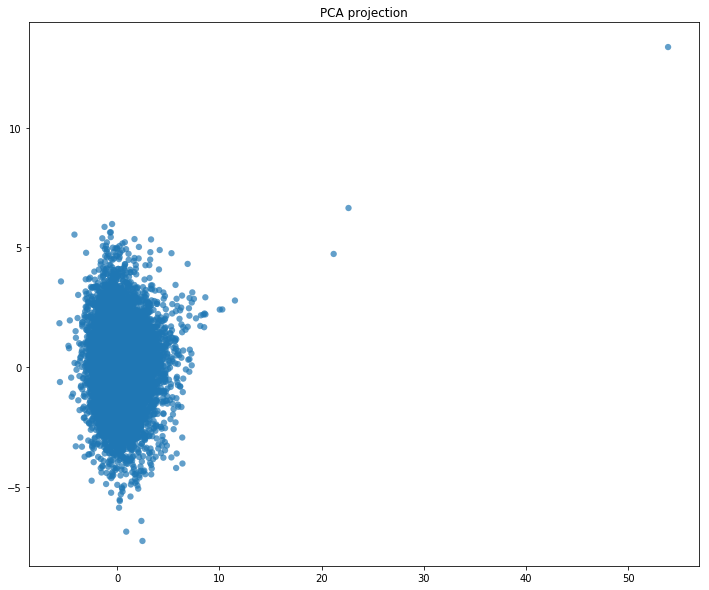

In [134]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
X_reduced.shape

print('Projecting %d-dimensional data to 2D' % X.shape[1])
plt.figure(figsize=(12,10))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1],edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
# plt.colorbar()
plt.title('PCA projection');


In [132]:
X_reduced = [x[1] for x in list(X_reduced)]

In [67]:
pca = PCA(n_components=1)
pca.fit(X)
X_reduced = pca.transform(X)
X_reduced.shape

(48282, 1)

Projecting 2-dimensional data to 1D


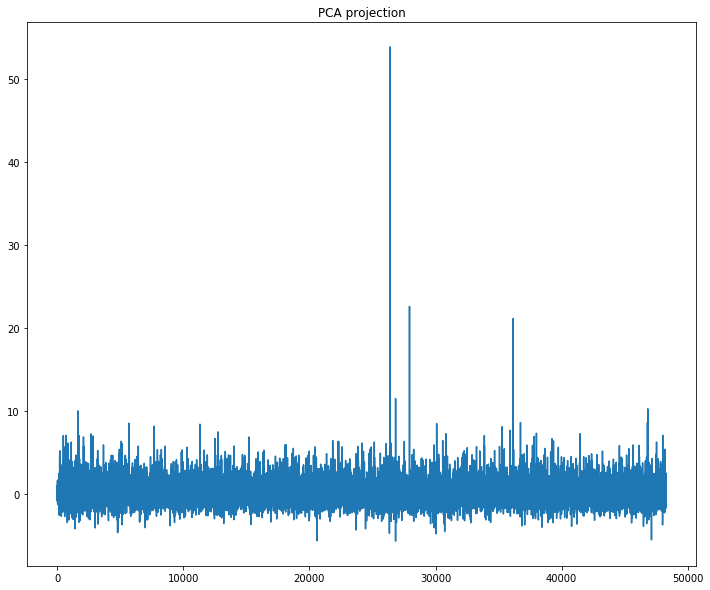

In [135]:
print('Projecting %d-dimensional data to 1D' % X.shape[1])
plt.figure(figsize=(12,10))

plt.plot(X_reduced[:, 0])
plt.title('PCA projection');

In [89]:
X_reduced = [x[0] for x in list(X_reduced)]

Type:        list
String form: [-0.9551311014671762, -0.7685107105542515, -0.7685107105542515, -0.37085499120705445, 0.653947072 <...> 326368437149958, -0.5201574874882844, 0.6175997428504019, -1.0898176482519444, 5.017744618554668]
Length:      48282
Docstring:  
list() -> new empty list
list(iterable) -> new list initialized from iterable's items


In [ ]:
X_reduced

In [106]:
zipped = zip(list(pos.keys()),X_reduced)
sorted_x = sorted(zipped, key = lambda t: t[1], reverse=True)
sorted_dict = collections.OrderedDict(sorted_x)

In [93]:
tf_df = pd.read_excel('./out/kw_dp_term_frequency_total.xlsx')

In [148]:
filter_dict = collections.OrderedDict()
re_ = r"^A |^THE |^THEIR |^ITS |^THIS |^AN |^SUCH A |^AS |^TO |^AND |^-PRON- |AT LEAST|USE THEREOF|^OR | THEREOF| THEREFOR| THERETO| THEREFROM| THEREBY"
for k, v in sorted_dict.items():
    k = re.sub(re_, "", k.upper())
    if  k.count(' ') < 4 and  k.count(' ') >= 1 and k.count('(') == 0 and k.count(')') == 0:
        if True or k.upper() in tf_df['Unnamed: 0'].values:
#             print(k.upper(),tf_df[tf_df['Unnamed: 0'] == k.upper()]['frequency'])
            tf_s = tf_df[tf_df['Unnamed: 0'] == k.upper()]['frequency']
            if not tf_s.empty and  tf_s.values[0] > 20 and k not in filter_dict:
                filter_dict[k] = (tf_s.values[0], v)
filter_df = pd.DataFrame(filter_dict).T.rename_axis('kw').add_prefix('value').reset_index()

In [150]:
filter_df.to_excel('./out/kws_dp_GCN_top1_2_pca2.xlsx')

In [149]:
filter_df

kw  value0     value1
0                  SECONDARY BATTERY  1132.0  26.000441
1                  ELECTRICAL DEVICE    51.0   2.700908
2                      POLYMER BLEND    35.0   2.489519
3                             T CELL    33.0   2.068599
4                   SYNTHESIS METHOD    37.0   1.972987
...                              ...     ...        ...
1054  EXHAUST GAS PURIFYING CATALYST    64.0  -1.218886
1055                      POWER TOOL    21.0  -1.293303
1056               ABSORBENT ARTICLE    61.0  -1.318788
1057                    CONTACT LENS    22.0  -1.366557
1058                ANTICANCER AGENT    40.0  -1.874197

[1059 rows x 3 columns]

In [8]:
nodes.index('SEMICONDUCTOR DEVICE')

31253

In [122]:
tf_df[tf_df['Unnamed: 0'] == 'OPERATING HYDROGEN GENERATING APPARATUS']['frequency'].values[0]

1